In [2]:
import requests
import datetime
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt

def to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d")

In [3]:
dts = pd.read_csv('购买状态列表3.csv')

In [117]:
dts.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,最后购买,天数,状态,购买数,购买金额,消费习惯,花销
0,0,0,0,20147,2019-04-12,59,静默,3.0,26.200000,剁手,一般人
1,1,1,1,20156,2019-05-26,15,活跃,11.0,101.599999,剁手,有钱人
2,2,2,2,22088,2019-05-13,28,活跃,10.0,135.499998,剁手,有钱人
3,3,3,3,23837,2019-05-23,18,活跃,7.0,108.839999,剁手,有钱人
4,4,4,4,30292,2019-05-30,11,活跃,35.0,1192.410000,剁手,有钱人


In [4]:
dts=dts.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'],axis=1)

In [119]:
dts.head()

,id,最后购买,天数,状态,购买数,购买金额,消费习惯,花销
0,20147,2019-04-12,59,静默,3.0,26.200000,剁手,一般人
1,20156,2019-05-26,15,活跃,11.0,101.599999,剁手,有钱人
2,22088,2019-05-13,28,活跃,10.0,135.499998,剁手,有钱人
3,23837,2019-05-23,18,活跃,7.0,108.839999,剁手,有钱人
4,30292,2019-05-30,11,活跃,35.0,1192.410000,剁手,有钱人


In [5]:
bar = progressbar
worth_try,worth_look,worth_comp=[],[],[]
for i in bar.progressbar(range(len(dts))):
    if dts.iloc[i]['状态'] == '静默' and dts.iloc[i]['消费习惯']=='剁手' and dts.iloc[i]['花销']=='有钱人':
        worth_try.append(dts.iloc[i]['id'])
    elif dts.iloc[i]['状态'] == '活跃' and dts.iloc[i]['消费习惯']=='剁手' and dts.iloc[i]['花销']=='有钱人':
        worth_look.append(dts.iloc[i]['id'])
    elif dts.iloc[i]['状态'] == '活跃' and dts.iloc[i]['消费习惯']=='剁手' and dts.iloc[i]['花销']=='一般人':
        worth_comp.append(dts.iloc[i]['id'])
    else:
        continue

100% (64856 of 64856) |##################| Elapsed Time: 0:01:13 Time:  0:01:13


In [16]:
len(worth_try)# 快流失的有钱人

2683

In [122]:
len(worth_look)#活跃的有钱人

19685

In [56]:
len(worth_comp)# 活跃的一般人

1842

31    0.063362
32    0.128215
33    0.089452
34    0.124488
35    0.130824
Name: doc_count, dtype: float64

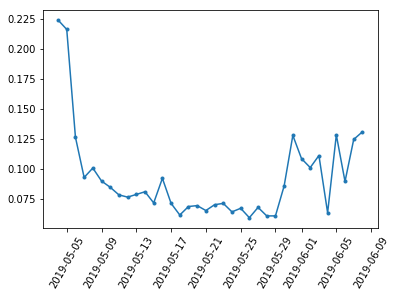

In [57]:
dsl11 = {
        'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['index', '首页']}},
                             {'terms': {'user_id': [str(x) for x in worth_try]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es11 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res11 = es11.search(index='shop_pv_event', doc_type='pv_event', body=dsl11,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df11 = json_normalize(res11['aggregations']['my_buckets']['buckets'])
df11.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df11.columns))
df11['日期'] = df11['日期'].apply(to_date)
df11['日期'] = pd.to_datetime(df11['日期'])


df11['doc_count']=df11['doc_count']/len(worth_try)
plt.plot(df11['日期'],df11['doc_count'],marker='.')
plt.xticks(rotation='60')
df11['doc_count'].tail()

31    0.242875
32    0.235509
33    0.187402
34    0.214478
35    0.233934
Name: doc_count, dtype: float64

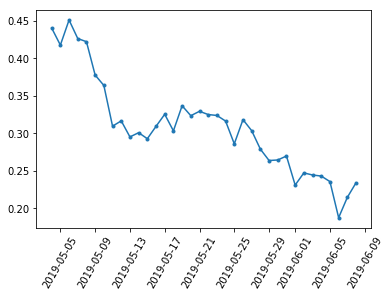

In [58]:
dsl21 = {
        'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['index', '首页']}},
                             {'terms': {'user_id': [str(x) for x in worth_look]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es21 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res21 = es21.search(index='shop_pv_event', doc_type='pv_event', body=dsl21,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df21 = json_normalize(res21['aggregations']['my_buckets']['buckets'])
df21.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df21.columns))
df21['日期'] = df21['日期'].apply(to_date)
df21['日期'] = pd.to_datetime(df21['日期'])
df21['doc_count']=df21['doc_count']/len(worth_look)
plt.plot(df21['日期'],df21['doc_count'],marker='.')
plt.xticks(rotation='60')
df21['doc_count'].tail()

31    0.105320
32    0.051574
33    0.042888
34    0.047774
35    0.060803
Name: doc_count, dtype: float64

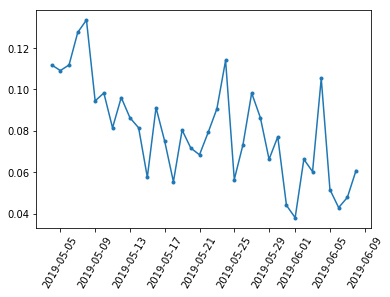

In [59]:
dsl31 = {
        'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['index', '首页']}},
                             {'terms': {'user_id': [str(x) for x in worth_comp]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es31 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res31 = es31.search(index='shop_pv_event', doc_type='pv_event', body=dsl31,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df31 = json_normalize(res31['aggregations']['my_buckets']['buckets'])
df31.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df31.columns))
df31['日期'] = df31['日期'].apply(to_date)
df31['日期'] = pd.to_datetime(df31['日期'])
df31['doc_count']=df31['doc_count']/len(worth_comp)
plt.plot(df31['日期'],df31['doc_count'],marker='.')
plt.xticks(rotation='60')
df31['doc_count'].tail()

(array([737184., 737188., 737192., 737196., 737200., 737204., 737208.,
        737211., 737215., 737219.]), <a list of 10 Text xticklabel objects>)

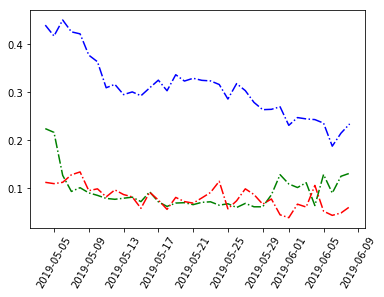

In [60]:
#首页
plt.plot(df11['日期'],df11['doc_count'],'g-.',   #绿色    静默有钱人    
         df21['日期'],df21['doc_count'],'b-.',  #蓝色    活跃有钱人
         df31['日期'],df31['doc_count'],'r-.')   #红色    活跃一般人
plt.xticks(rotation='60')

In [61]:
dsl32 = {
        'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['detail', '商家详情']}},
                             {'terms': {'user_id': [str(x) for x in worth_comp]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es32 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res32 = es32.search(index='shop_pv_event', doc_type='pv_event', body=dsl32,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df32 = json_normalize(res32['aggregations']['my_buckets']['buckets'])
df32.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df32.columns))
df32['日期'] = df32['日期'].apply(to_date)
df32['日期'] = pd.to_datetime(df32['日期'])
df32['doc_count']=df32['doc_count']/len(worth_comp)

In [62]:
dsl12 = {
        'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['detail', '商家详情']}},
                             {'terms': {'user_id': [str(x) for x in worth_try]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es12 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res12 = es12.search(index='shop_pv_event', doc_type='pv_event', body=dsl12,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df12 = json_normalize(res12['aggregations']['my_buckets']['buckets'])
df12.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df12.columns))
df12['日期'] = df12['日期'].apply(to_date)
df12['日期'] = pd.to_datetime(df12['日期'])
df12['doc_count']=df12['doc_count']/len(worth_try)
df12['doc_count'].tail()

31    0.139396
32    0.191949
33    0.096906
34    0.171450
35    0.131196
Name: doc_count, dtype: float64

In [63]:
dsl22 = {
        'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['detail', '商家详情']}},
                             {'terms': {'user_id': [str(x) for x in worth_look]}},
                             #{'terms': {'event_type': ['event']}}
                        ]}}}
es22 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res22 = es32.search(index='shop_pv_event', doc_type='pv_event', body=dsl22,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df22 = json_normalize(res22['aggregations']['my_buckets']['buckets'])
df22.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df22.columns))
df22['日期'] = df22['日期'].apply(to_date)
df22['日期'] = pd.to_datetime(df22['日期'])
df22['doc_count']=df22['doc_count']/len(worth_look)
df22['doc_count'].tail()

31    0.319990
32    0.308560
33    0.239624
34    0.280671
35    0.268275
Name: doc_count, dtype: float64

(array([737184., 737188., 737192., 737196., 737200., 737204., 737208.,
        737211., 737215., 737219.]), <a list of 10 Text xticklabel objects>)

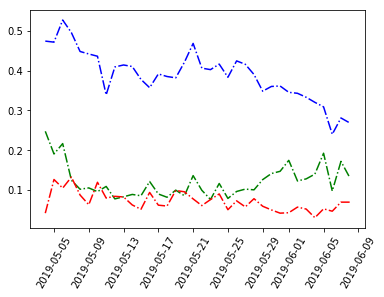

In [64]:
#商家详情页
plt.plot(df12['日期'],df12['doc_count'],'g-.',   #绿色   静默有钱人
         df12['日期'],df22['doc_count'],'b-.',  #蓝色   活跃有钱人
         df12['日期'],df32['doc_count'],'r-.')   #红色   活跃一般人
plt.xticks(rotation='60')

In [65]:
['discount-list', '五折日历列表页']
dsl13 = {
        'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['discount-list', '五折日历列表页']}},
                             {'terms': {'user_id': [str(x) for x in worth_try]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es13 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res13 = es13.search(index='shop_pv_event', doc_type='pv_event', body=dsl13,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df13 = json_normalize(res13['aggregations']['my_buckets']['buckets'])
df13.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df13.columns))
df13['日期'] = df13['日期'].apply(to_date)
df13['日期'] = pd.to_datetime(df13['日期'])
df13['doc_count']=df13['doc_count']/len(worth_try)

dsl23 = {
        'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['discount-list', '五折日历列表页']}},
                             {'terms': {'user_id': [str(x) for x in worth_look]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es23 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res23 = es23.search(index='shop_pv_event', doc_type='pv_event', body=dsl23,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df23 = json_normalize(res23['aggregations']['my_buckets']['buckets'])
df23.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df23.columns))
df23['日期'] = df23['日期'].apply(to_date)
df23['日期'] = pd.to_datetime(df23['日期'])
df23['doc_count']=df23['doc_count']/len(worth_look)

dsl33 = {
        'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['discount-list', '五折日历列表页']}},
                             {'terms': {'user_id': [str(x) for x in worth_comp]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es33 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res33 = es33.search(index='shop_pv_event', doc_type='pv_event', body=dsl33,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df33 = json_normalize(res33['aggregations']['my_buckets']['buckets'])
df33.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df33.columns))
df33['日期'] = df33['日期'].apply(to_date)
df33['日期'] = pd.to_datetime(df33['日期'])
df33['doc_count']=df33['doc_count']/len(worth_comp)

(array([737184., 737188., 737192., 737196., 737200., 737204., 737208.,
        737211., 737215., 737219.]), <a list of 10 Text xticklabel objects>)

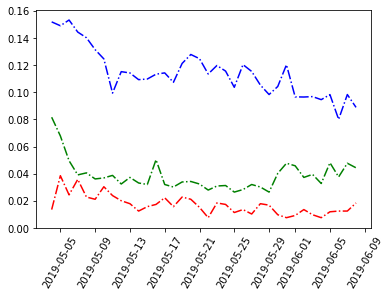

In [66]:
#五折日历
plt.plot(df13['日期'],df13['doc_count'],'g-.',   #绿色   静默有钱人
         df23['日期'],df23['doc_count'],'b-.',  #蓝色   活跃有钱人
         df33['日期'],df33['doc_count'],'r-.')   #红色   活跃一般人
plt.xticks(rotation='60')

(array([737184., 737188., 737192., 737196., 737200., 737204., 737208.,
        737211., 737215., 737219.]), <a list of 10 Text xticklabel objects>)

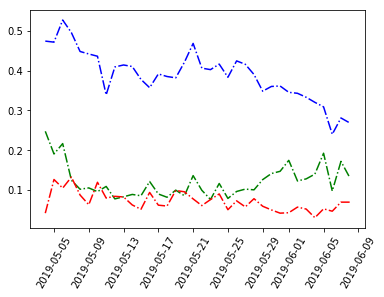

In [67]:
#详情页
plt.plot(df12['日期'],df12['doc_count'],'g-.',   #绿色   静默有钱人
         df12['日期'],df22['doc_count'],'b-.',  #蓝色   活跃有钱人
         df12['日期'],df32['doc_count'],'r-.')   #红色   活跃一般人
plt.xticks(rotation='60')

(array([737184., 737188., 737192., 737196., 737200., 737204., 737208.,
        737211., 737215., 737219.]), <a list of 10 Text xticklabel objects>)

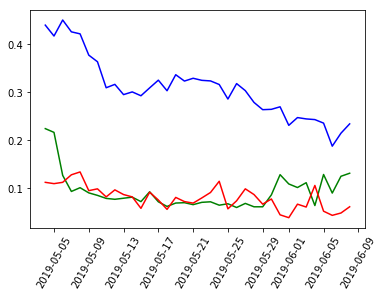

In [68]:
#首页
plt.plot(df11['日期'],df11['doc_count'],'g-',   #绿色    静默有钱人    
         df21['日期'],df21['doc_count'],'b-',  #蓝色    活跃有钱人
         df31['日期'],df31['doc_count'],'r-')   #红色    活跃一般人
plt.xticks(rotation='60')

(array([737184., 737188., 737192., 737196., 737200., 737204., 737208.,
        737211., 737215., 737219.]), <a list of 10 Text xticklabel objects>)

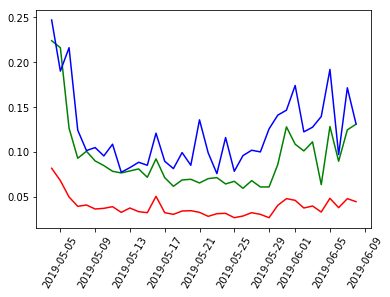

In [69]:
#首页
plt.plot(df11['日期'],df11['doc_count'],'g-',   #绿色    首页
         df12['日期'],df12['doc_count'],'b-',  #蓝色    详情页
         df13['日期'],df13['doc_count'],'r-', )  #红色    五折日历
plt.xticks(rotation='60')

In [70]:
#{'terms': {'event_name': ['个人中心']}}
dsl14 = {
        'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['我的黑卡', 'home']}},
                             {'terms': {'user_id': [str(x) for x in worth_try]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es14 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res14 = es14.search(index='shop_pv_event', doc_type='pv_event', body=dsl14,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df14 = json_normalize(res14['aggregations']['my_buckets']['buckets'])
df14.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df14.columns))
df14['日期'] = df14['日期'].apply(to_date)
df14['日期'] = pd.to_datetime(df14['日期'])
df14['doc_count']=df14['doc_count']/len(worth_try)

dsl24 = {
        'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['我的黑卡', 'home']}},
                             {'terms': {'user_id': [str(x) for x in worth_look]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es24 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res24 = es24.search(index='shop_pv_event', doc_type='pv_event', body=dsl24,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df24 = json_normalize(res24['aggregations']['my_buckets']['buckets'])
df24.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df24.columns))
df24['日期'] = df24['日期'].apply(to_date)
df24['日期'] = pd.to_datetime(df24['日期'])
df24['doc_count']=df24['doc_count']/len(worth_look)

dsl34 = {
        'aggs': {'my_buckets': {'aggregations': {},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['我的黑卡', 'home']}},
                             {'terms': {'user_id': [str(x) for x in worth_comp]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es34 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res34 = es34.search(index='shop_pv_event', doc_type='pv_event', body=dsl34,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df34 = json_normalize(res34['aggregations']['my_buckets']['buckets'])
df34.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df34.columns))
df34['日期'] = df34['日期'].apply(to_date)
df34['日期'] = pd.to_datetime(df34['日期'])
df34['doc_count']=df34['doc_count']/len(worth_comp)

In [74]:
df34.head()

,doc_count,日期
0,0.002172,2019-05-22
1,0.009229,2019-05-23
2,0.013029,2019-05-24
3,0.003800,2019-05-25
4,0.008143,2019-05-26


In [73]:
df24.head()

,doc_count,日期
0,0.003505,2019-05-22
1,0.020574,2019-05-23
2,0.024740,2019-05-24
3,0.023470,2019-05-25
4,0.021387,2019-05-26


In [75]:
df14.head()

,doc_count,日期
0,0.001864,2019-05-22
1,0.005218,2019-05-23
2,0.004473,2019-05-24
3,0.006709,2019-05-25
4,0.005963,2019-05-26


(array([737202., 737204., 737206., 737208., 737210., 737211., 737213.,
        737215., 737217.]), <a list of 9 Text xticklabel objects>)

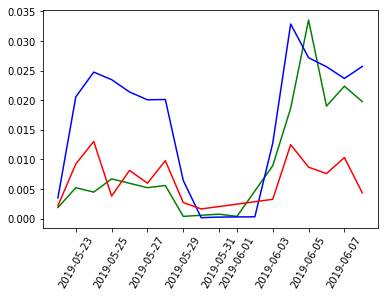

In [76]:
#我的黑卡
plt.plot(df14['日期'],df14['doc_count'],'g-',   #绿色    静默有钱人    
         df24['日期'],df24['doc_count'],'b-',  #蓝色    活跃有钱人
         df34['日期'],df34['doc_count'],'r-')   #红色    活跃一般人
plt.xticks(rotation='60')

In [ ]:
{'人数(UV)': {'cardinality': {'field': 'uuid', 'precision_threshold': 100}}}

In [30]:
dsl13_1 = {
        'aggs': {'my_buckets': {'aggregations': {'人数(UV)': {'cardinality': {'field': 'uuid', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['discount-list', '五折日历列表页']}},
                             {'terms': {'user_id': [str(x) for x in worth_try]}},
                             #{'terms': {'event_type': ['event']}}
                        ]}}}
es13_1 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res13_1 = es13_1.search(index='shop_pv_event', doc_type='pv_event', body=dsl13_1,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df13_1 = json_normalize(res13_1['aggregations']['my_buckets']['buckets'])
df13_1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df13_1.columns))
df13_1['日期'] = df13_1['日期'].apply(to_date)
df13_1['日期'] = pd.to_datetime(df13_1['日期'])
df13_1.head()

,doc_count,日期,人数(UV).value
0,219,2019-05-04,137
1,182,2019-05-05,108
2,133,2019-05-06,84
3,105,2019-05-07,76
4,109,2019-05-08,85


In [31]:
df13_1['点击率']=df13_1['人数(UV).value']/len(worth_try)

In [43]:
dsl23_1 = {
        'aggs': {'my_buckets': {'aggregations': {'人数(UV)': {'cardinality': {'field': 'uuid', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['discount-list', '五折日历列表页']}},
                             {'terms': {'user_id': [str(x) for x in worth_look]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es23_1 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res23_1 = es23_1.search(index='shop_pv_event', doc_type='pv_event', body=dsl23_1,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df23_1 = json_normalize(res23_1['aggregations']['my_buckets']['buckets'])
df23_1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df23_1.columns))
df23_1['日期'] = df23_1['日期'].apply(to_date)
df23_1['日期'] = pd.to_datetime(df23_1['日期'])
df23_1.head()

,doc_count,日期,人数(UV).value
0,2990,2019-05-04,1685
1,2934,2019-05-05,1638
2,3017,2019-05-06,1716
3,2842,2019-05-07,1584
4,2760,2019-05-08,1622


In [44]:
df23_1['点击率']=df23_1['人数(UV).value']/len(worth_look)
df23_1.head()

,doc_count,日期,人数(UV).value,点击率
0,2990,2019-05-04,1685,0.085598
1,2934,2019-05-05,1638,0.083211
2,3017,2019-05-06,1716,0.087173
3,2842,2019-05-07,1584,0.080467
4,2760,2019-05-08,1622,0.082398


In [39]:
dsl33_1 = {
        'aggs': {'my_buckets': {'aggregations': {'人数(UV)': {'cardinality': {'field': 'uuid', 'precision_threshold': 100}}},
                         'composite': {'size': 9999999,
                                       'sources': [
                                           {'日期': {'date_histogram': {'field': 'created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+08:00'}}}
                                       ]}}},
         'query': {'bool': {'must': [#{'query_string': {'query': "group_category_name='早餐档'"}},
                                     {'range': {'created': {'format': 'yyyy-MM-dd',
                                                    'gte': '2019-05-05',
                                                    'lte': '2019-06-09',
                                                    'time_zone': '+08:00'}}},
                             {'terms': {'app_name': ['vip-mini']}},
                             {'terms': {'event_name': ['discount-list', '五折日历列表页']}},
                             {'terms': {'user_id': [str(x) for x in worth_comp]}},
                            # {'terms': {'event_type': ['event']}}
                        ]}}}
es33_1 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res33_1 = es33.search(index='shop_pv_event', doc_type='pv_event', body=dsl33_1,
                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                search_type='query_then_fetch')
df33_1 = json_normalize(res33_1['aggregations']['my_buckets']['buckets'])
df33_1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df33_1.columns))
df33_1['日期'] = df33_1['日期'].apply(to_date)
df33_1['日期'] = pd.to_datetime(df33_1['日期'])
df33_1.head()

,doc_count,日期,人数(UV).value
0,25,2019-05-04,21
1,71,2019-05-05,37
2,45,2019-05-06,31
3,66,2019-05-07,40
4,42,2019-05-08,31


In [41]:
df33_1['点击率']=df33_1['人数(UV).value']/len(worth_comp)

In [45]:
df33_1.head()

,doc_count,日期,人数(UV).value,点击率
0,25,2019-05-04,21,0.011401
1,71,2019-05-05,37,0.020087
2,45,2019-05-06,31,0.016830
3,66,2019-05-07,40,0.021716
4,42,2019-05-08,31,0.016830


(array([737184., 737188., 737192., 737196., 737200., 737204., 737208.,
        737211., 737215., 737219.]), <a list of 10 Text xticklabel objects>)

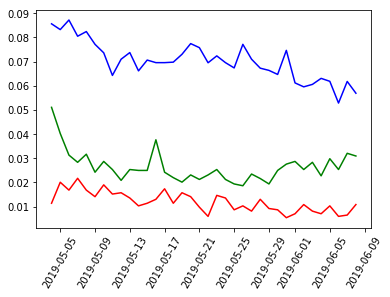

In [51]:
#五折日历
plt.plot(df13_1['日期'],df13_1['点击率'],'g-',   #绿色   静默有钱人
         df23_1['日期'],df23_1['点击率'],'b-',  #蓝色   活跃有钱人
         df33_1['日期'],df33_1['点击率'],'r-')   #红色   活跃一般人
plt.xticks(rotation='60')

(array([737184., 737188., 737192., 737196., 737200., 737204., 737208.,
        737211., 737215., 737219.]), <a list of 10 Text xticklabel objects>)

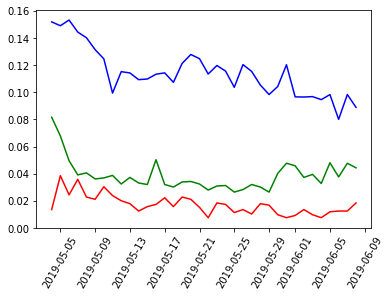

In [50]:
#五折日历
plt.plot(df13['日期'],df13['doc_count'],'g-',   #绿色   静默有钱人
         df23['日期'],df23['doc_count'],'b-',  #蓝色   活跃有钱人
         df33['日期'],df33['doc_count'],'r-')   #红色   活跃一般人
plt.xticks(rotation='60')